In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np
from numpy import array
import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings
 
 
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import time
 
from sklearn.pipeline import Pipeline
from sklearn.metrics import  mean_squared_error, mean_absolute_error , r2_score
from sklearn.metrics import  accuracy_score, precision_score , recall_score , f1_score , roc_auc_score , confusion_matrix, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef

import xgboost as xgb
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import StratifiedKFold




## Feature Selection

In [7]:
# Load the data
path="c:/Users/mohammad/Desktop/Ghasemi/csvdetailed_400_dataset.csv"
df= pd.read_csv(path, sep=',')

In [9]:

# تابع بررسی مقادیر missing
def check_missing(df):
    missing_info = []
    for col in df.columns.tolist():
        if df[col].isnull().sum() > 0:
            missing_info.append('{} column missing values: {}, datatype: {}'.format(col, df[col].isnull().sum(), df[col].dtype))
    return missing_info

# شناسایی ستون‌های عددی و دسته‌بندی
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# نمایش مقادیر missing قبل از اعمال ایمپیوتر
missing_before = check_missing(df)
print("Missing values before imputation:")
for info in missing_before:
    print(info)

# ایجاد SimpleImputer برای ستون‌های عددی و دسته‌بندی
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# اعمال ایمپیوتر بر روی ستون‌های عددی
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# بررسی ستون‌های دسته‌بندی خالی
# فقط ستون‌های غیر خالی را برای ایمپیوتر ارسال می‌کنیم
valid_categorical_cols = [col for col in categorical_cols if df[col].notna().sum() > 0]

# اعمال ایمپیوتر بر روی ستون‌های دسته‌بندی معتبر
if valid_categorical_cols:
    df[valid_categorical_cols] = pd.DataFrame(cat_imputer.fit_transform(df[valid_categorical_cols]), columns=valid_categorical_cols)
else:
    print("No valid categorical columns for imputation")

# بررسی مقادیر missing بعد از اعمال ایمپیوتر
missing_after = check_missing(df)
print("Missing values after imputation:")
if missing_after:
    for info in missing_after:
        print(info)
else:
    print("No missing values.")


Missing values before imputation:
No valid categorical columns for imputation
Missing values after imputation:
No missing values.


In [10]:
# استخراج ستون هدف y و ستون‌های مستقل X قبل از تبدیل داده‌های دسته‌بندی
y = df['label']
X = df.drop(columns=['label'])

# استفاده از LabelEncoder برای تبدیل ستون‌های دسته‌بندی به کدهای عددی
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# تبدیل مقادیر y به اعداد و نمایش مقادیر تبدیل شده
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Original values:", list(y[:10]))  # چاپ 10 مقدار اول از y اولیه
print("Encoded values:", list(y_encoded[:10]))  # چاپ 10 مقدار اول از y تبدیل شده
print("Classes:", list(label_encoder.classes_))  # چاپ کلاس‌ها

# ادامه پیش‌پردازش و آموزش مدل
y = y_encoded

Original values: [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Encoded values: [0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Classes: [0.0, 1.0]


In [13]:
print(df['label'].value_counts(dropna=False))

label
1.0    222
0.0    178
Name: count, dtype: int64


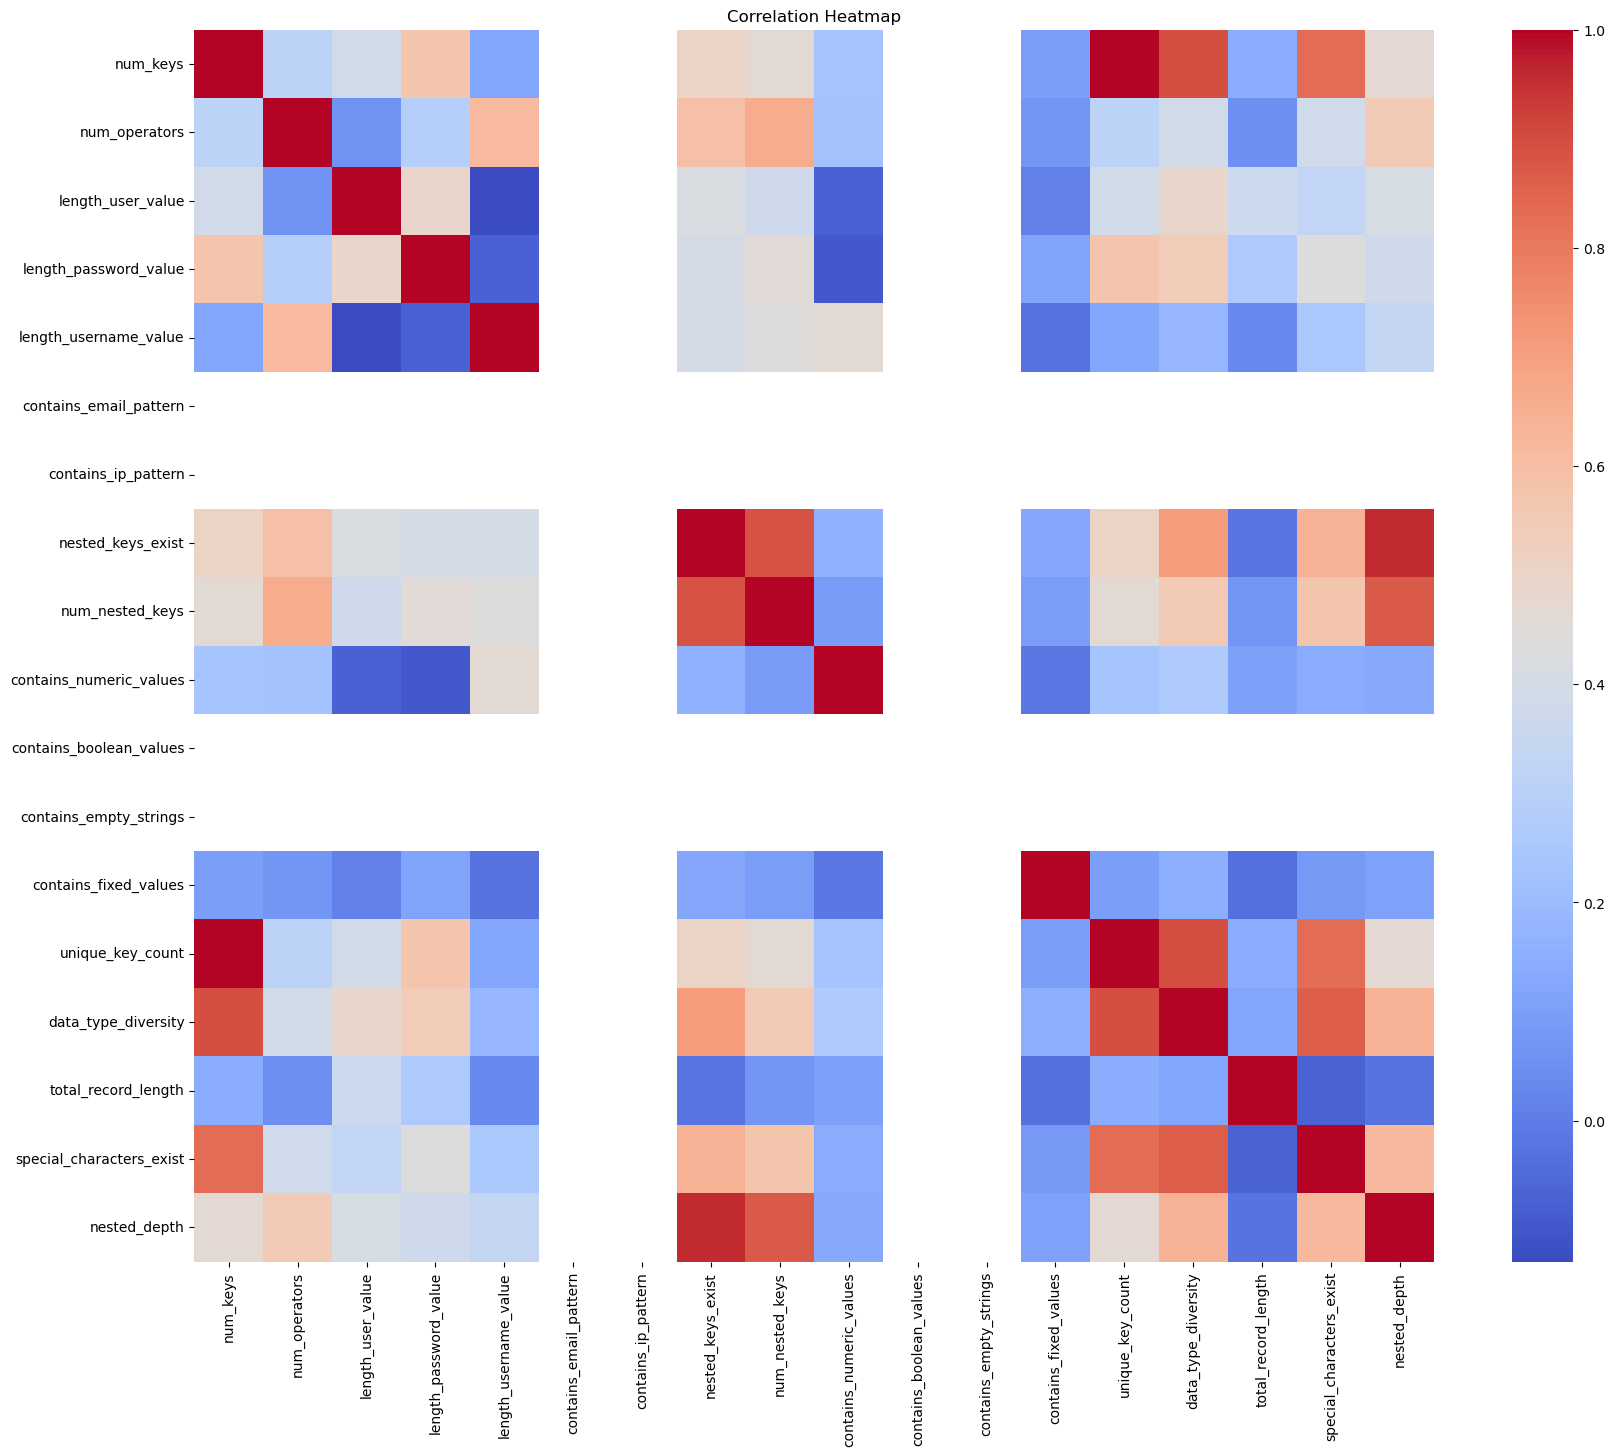

In [11]:

# محاسبه ماتریس همبستگی برای تمام ستون‌های X
correlation_matrix = X.corr()

# رسم هیت‌مپ همبستگی
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
# heatmap=sns.heatmap(correlation_matrix, annot=True, cbar=True, cmap='hot')
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

plt.title('Correlation Heatmap')
plt.show()

In [12]:
# شناسایی ویژگی‌هایی که باید حذف شوند
threshold = 0.9
col_corr = set()  # Set of all the names of correlated columns
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  # Absolute value of the correlation coefficient
            colname = correlation_matrix.columns[i]  # Getting the name of the column
            col_corr.add(colname)

# حذف ویژگی‌های با همبستگی بالا
X_reduced = X.drop(columns=col_corr)
# X = X_reduced 
print("Original shape:", X.shape)
print("Reduced shape:", X_reduced.shape)
X = X_reduced 
print("Original shape:", X.shape)

Original shape: (400, 18)
Reduced shape: (400, 16)
Original shape: (400, 16)


In [14]:
# تقسیم داده‌ها به مجموعه‌های آموزشی و آزمایشی
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# بررسی توزیع مقادیر y در مجموعه‌های آموزشی و آزمایشی
print("Distribution in y_train:", np.bincount(y_train))
print("Distribution in y_test:", np.bincount(y_test))

# استفاده از SMOTE برای تعادل داده‌ها در مجموعه آموزشی
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# استانداردسازی داده‌ها با استفاده از StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Distribution in y_train: [146 174]
Distribution in y_test: [32 48]
X_train shape: (348, 16)
X_test shape: (80, 16)
y_train shape: (348,)
y_test shape: (80,)


In [15]:
# ایجاد دیتافریم برای مقایسه عملکرد مدل‌ها
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'roc-Auc'])


## Model 

c:\ProgramData\anaconda3\envs\MachinLearning\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\MachinLearning\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\MachinLearning\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

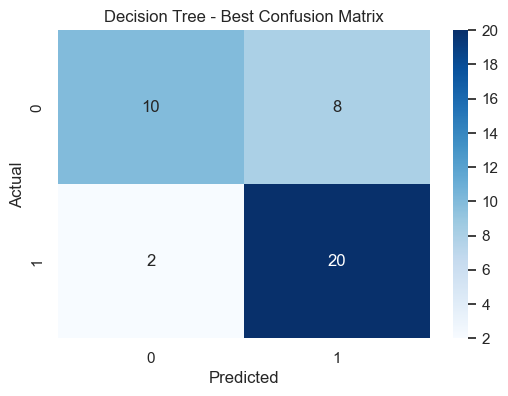

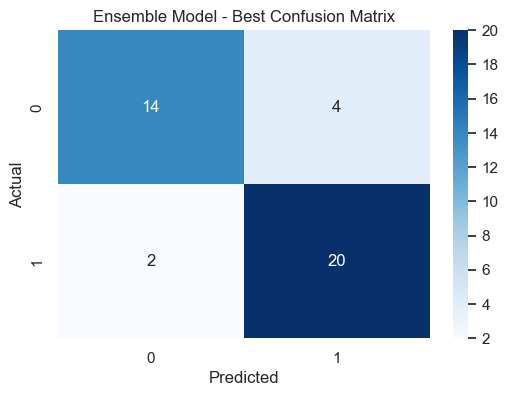

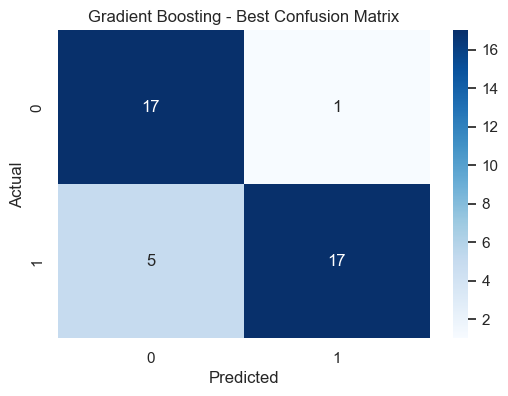

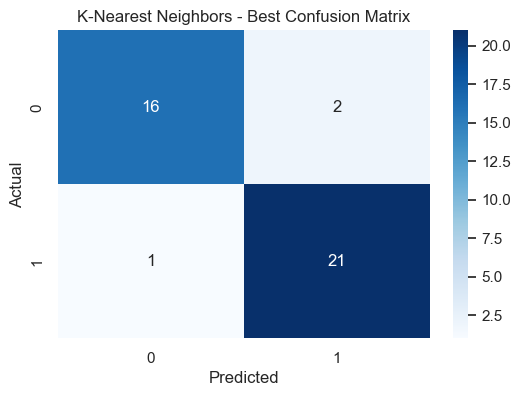

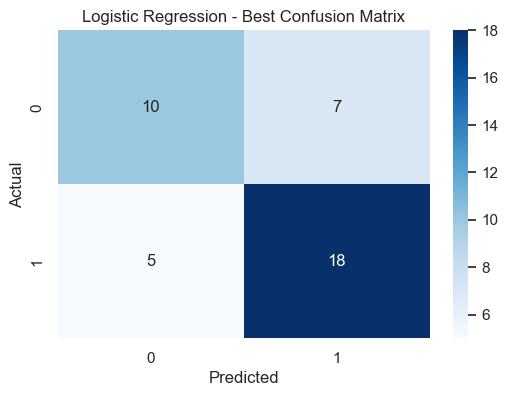

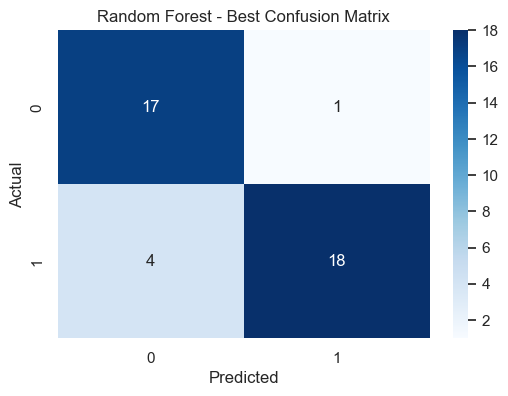

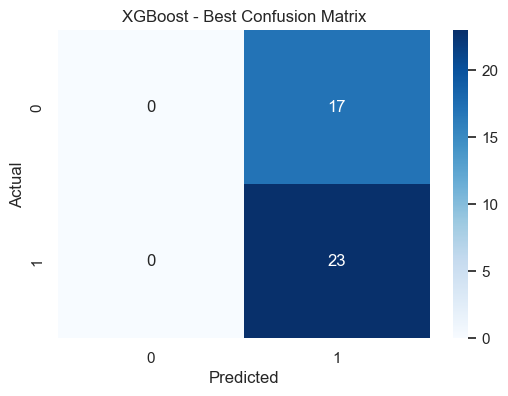


Final model performance comparison:
                 Model  Accuracy_Mean  AUC_Mean  Recall_Mean  Precision_Mean  \
0        Decision Tree         0.6250  0.653589     0.610981        0.623612   
1       Ensemble Model         0.6800  0.740938     0.663130        0.681616   
2    Gradient Boosting         0.7225  0.774595     0.716091        0.725684   
3  K-Nearest Neighbors         0.6950  0.672975     0.685490        0.688815   
4  Logistic Regression         0.6150  0.636665     0.596938        0.613482   
5        Random Forest         0.7050  0.749977     0.691576        0.708601   
6              XGBoost         0.5550  0.500000     0.500000        0.277500   

    F1_Mean  Kappa_Mean  MCC_Mean  
0  0.607606    0.226199  0.233939  
1  0.659459    0.333943  0.343943  
2  0.715193    0.434495  0.441511  
3  0.681821    0.373147  0.374336  
4  0.592442    0.199594  0.209525  
5  0.689410    0.389097  0.399474  
6  0.356887    0.000000  0.000000  


In [22]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# تعداد فولدها
n_splits = 10

# تابع برای اجرای K-Fold Cross-Validation و ثبت نتایج
def evaluate_model(model, model_name, X, y):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_performance = pd.DataFrame(columns=['Model', 'Fold', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC', 'Confusion Matrix'])
    
    fold_index = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        kappa = cohen_kappa_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # ذخیره نتایج به همراه ماتریس درهم‌ریختگی
        fold_performance.loc[fold_index] = [model_name, fold_index, accuracy, auc, recall, precision, f1, kappa, mcc, cm]
        fold_index += 1
    
    return fold_performance

# تعریف مدل‌ها
models = {
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=8, min_samples_split=5, min_samples_leaf=2, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, subsample=0.9, max_depth=8, min_samples_split=5, min_samples_leaf=2, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=16, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', n_estimators=500, learning_rate=0.05, max_depth=12, min_child_weight=50, gamma=0.1, colsample_bytree=0.8, subsample=0.8, random_state=42),
    'Ensemble Model': VotingClassifier(estimators=[
        ('lr', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=500, max_depth=16, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42)),
        ('xgb', xgb.XGBClassifier(objective='binary:logistic', n_estimators=500, learning_rate=0.05, max_depth=12, min_child_weight=50, gamma=0.1, colsample_bytree=0.8, subsample=0.8, random_state=42))
    ], voting='soft')
}

# اجرای مدل‌ها و جمع‌آوری نتایج
all_performances = pd.DataFrame()

for model_name, model in models.items():
    performance = evaluate_model(model, model_name, X, y)
    all_performances = pd.concat([all_performances, performance], ignore_index=True)

# محاسبه میانگین و انحراف معیار برای هر مدل
final_summary = all_performances.groupby('Model').agg(
    Accuracy_Mean=('Accuracy', 'mean'),
    AUC_Mean=('AUC', 'mean'),
    Recall_Mean=('Recall', 'mean'),
    Precision_Mean=('Prec.', 'mean'),
    F1_Mean=('F1', 'mean'),
    Kappa_Mean=('Kappa', 'mean'),
    MCC_Mean=('MCC', 'mean')
).reset_index()

# انتخاب بهترین فولد هر مدل بر اساس معیار Accuracy یا AUC (به دلخواه)
best_folds = all_performances.loc[all_performances.groupby('Model')['Accuracy'].idxmax()]

# نمایش و ذخیره ماتریس درهم‌ریختگی برای بهترین فولد هر مدل
for index, row in best_folds.iterrows():
    model_name = row['Model']
    cm = row['Confusion Matrix']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Best Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ذخیره نتایج نهایی در فایل CSV
final_summary.to_csv('best_model_performance_summary.csv', index=False)

# نمایش DataFrame نهایی
print("\nFinal model performance comparison:")
print(final_summary)


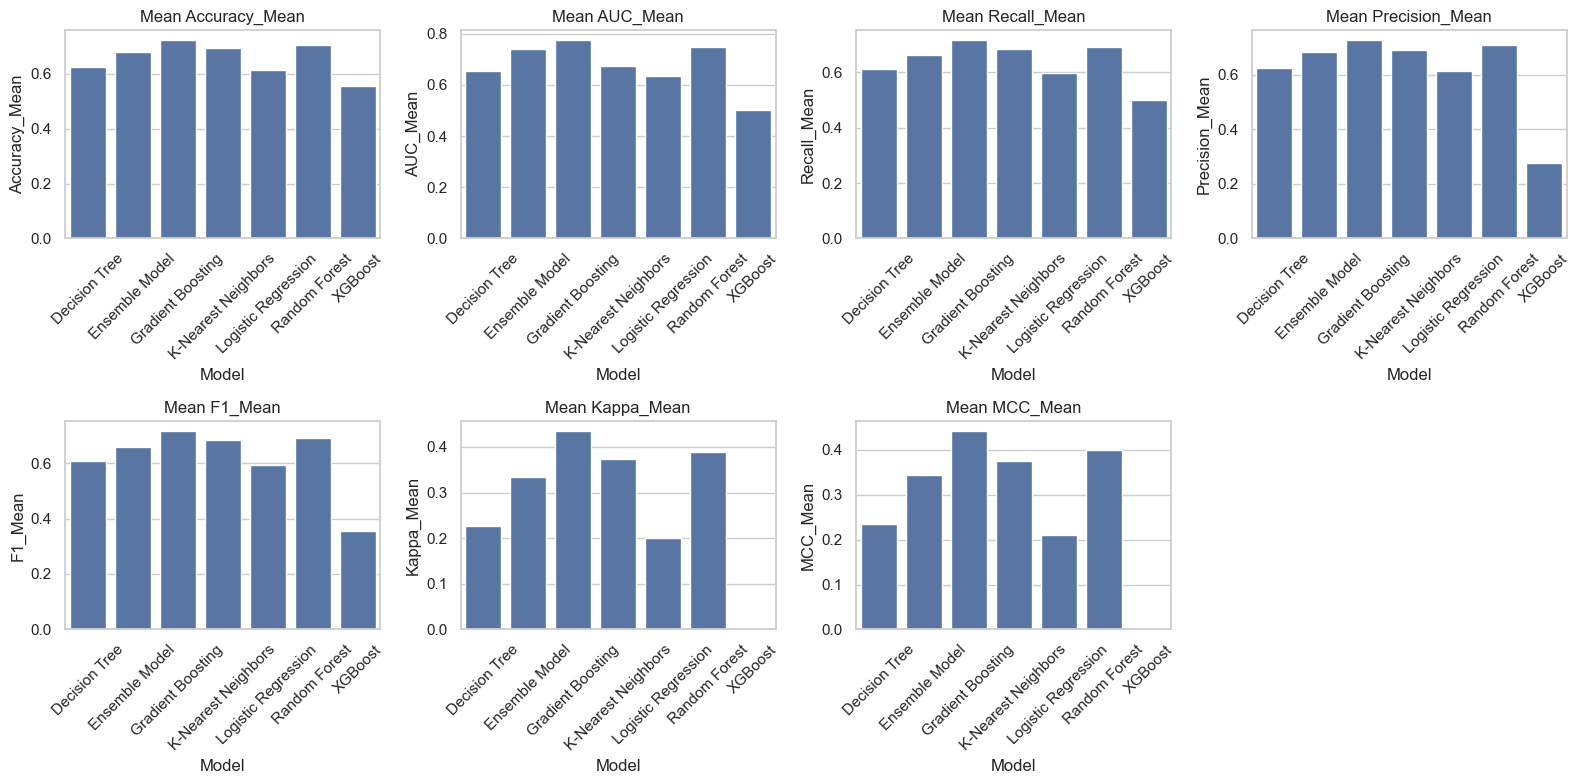

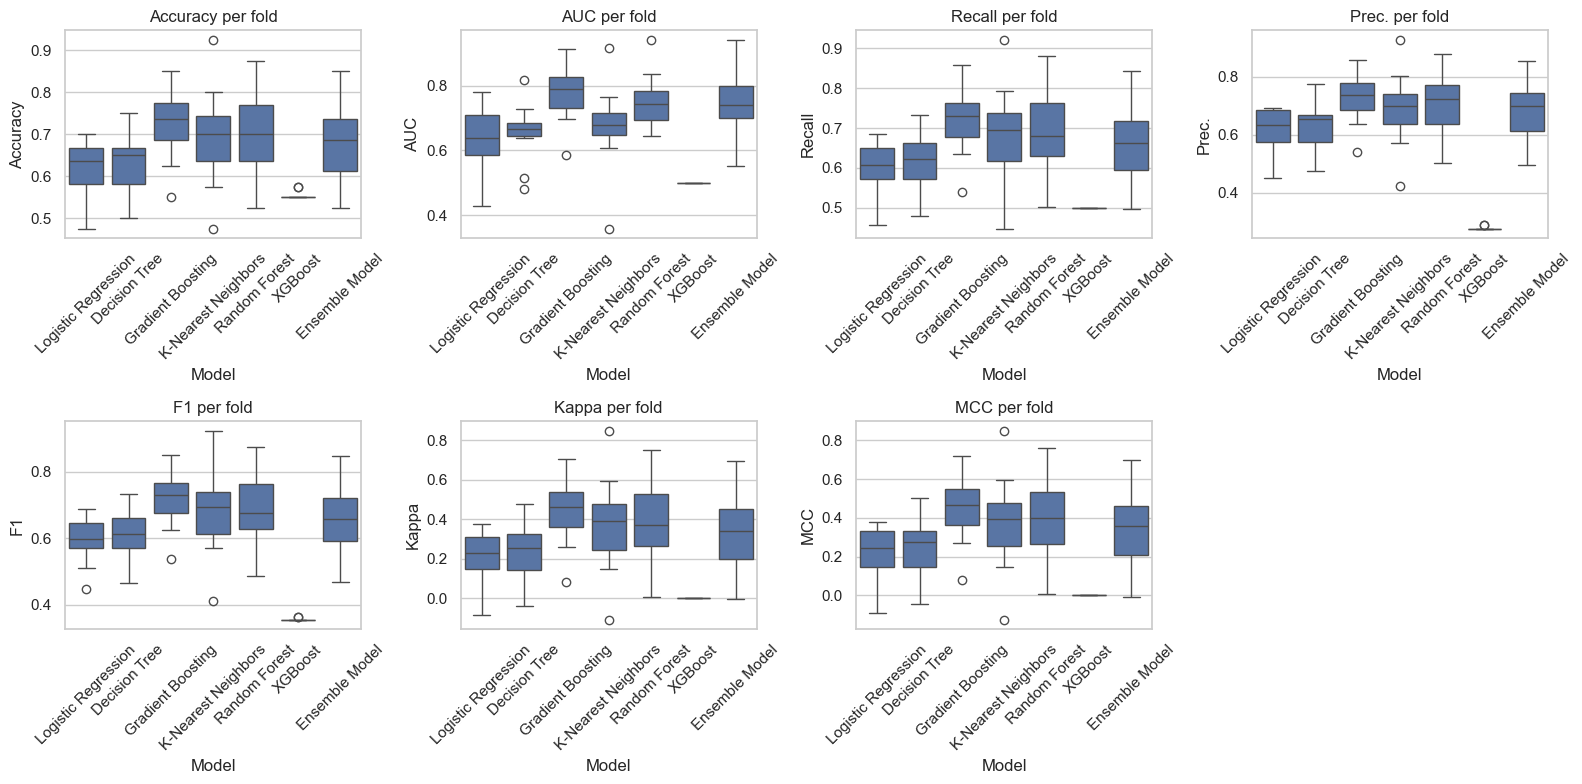

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# تنظیمات عمومی برای نمایش بهتر نمودارها
sns.set(style="whitegrid")

# رسم نمودار ستونی برای میانگین متریک‌ها
plt.figure(figsize=(16, 8))
metrics = ['Accuracy_Mean', 'AUC_Mean', 'Recall_Mean', 'Precision_Mean', 'F1_Mean', 'Kappa_Mean', 'MCC_Mean']
for i, metric in enumerate(metrics):
    plt.subplot(2, 4, i + 1)
    sns.barplot(x='Model', y=metric, data=final_summary)
    plt.title(f'Mean {metric}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# رسم نمودار جعبه‌ای برای هر متریک در هر مدل (Distribution per fold)
plt.figure(figsize=(16, 8))
metrics = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']
for i, metric in enumerate(metrics):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x='Model', y=metric, data=all_performances)
    plt.title(f'{metric} per fold')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
